# Exercise 1.12

Generate data as $Y = f(X) + ϵ$, where $f$ is a linear function and $ϵ$ is “noise”.

- Fit prediction methods with increasing complexity (k-nearest-neighbour and
polynomial regression).
- Measure the empirical mean$^1$ of the training error in dependence of the complexity parameters.
- Generate a test set with the same distribution, and compute the empirical mean of the test error in dependence of the complexity parameter.
- Repeat the previous task with f polynomial (with different degrees) and nonpolynomial.

Represent also the results through one or more (summarising and explanatory) pictures.

---

$^1$ The mean is computed over several samples with the same distribution.

## Preamble

In [ ]:
import numpy as np  # array and random

# models
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.linear_model   import LinearRegression
from sklearn.metrics        import mean_squared_error
from sklearn.pipeline       import make_pipeline

# graphics
from matplotlib.pyplot import subplots
from matplotlib        import colormaps
from matplotlib.colors import Normalize
from matplotlib.cm     import ScalarMappable


rng = np.random.default_rng(2025)   # fix random seed for reproducibility

## Generate data


Generate data as $\ Y = f(X) + \varepsilon\ $ where $\ f(x) = ax+b\ $ and $\ \varepsilon \sim \mathcal{N}(0,\sigma)\ $.

In [ ]:
n = 200       # number of sample points
sigma = 0.25  # noise standard deviation

X = rng.random((n,1))  # generate `n` random features
                       # (the models API needs a 2D array)

a = 2.0
b = 1.0
fX = a*X + b

eps = rng.normal(loc   = 0,        # generate gaussian noise with mean 0
                 scale = sigma,    # ... std `sigma` ...
                 size  = X.shape)  # ... same size as `X`

Y = fX + eps

$X$ constitutes the features and $Y$ the labels of our training data.

## Fit the models (training)

In [ ]:
m = 10    # number of different values for the parameter

Fit a $k$-nearest-neighbour model for various values of $k$.

In [ ]:
# generate `m` values of `k` from 1 to `n`
# (we need to round to have integers and cast to a list for plot)
ks = list(map(round, np.linspace(1, n, m)))
results_knn = {}    # initialize dictionary

for k in ks:
  knn = KNeighborsRegressor(n_neighbors=k)  # create knn model
  knn.fit(X,Y)                              # fit the model

  y_pred = knn.predict(X)                   # predict on the training data
  err = mean_squared_error(Y, y_pred)       # compute training errors
  results_knn[k] = {                        # add to dictionary
      "model":      knn,
      "err_train":  err
  }

Fit a polynomial regression model for various degrees. \\
Note that polynomial regression is just linear regression on $\ \{1,x,x^2,\dots,x^d\}\ $.

In [ ]:
degrees = list(map(round, np.linspace(1, n, m)))
results_poly = {}

for d in degrees:
  # expand x in [1, x, x^2, ..., x^d]
  # for the multivariate X there are also the cross-terms up to degree d
  poly = PolynomialFeatures(degree=d, include_bias=True)
  Xp = poly.fit_transform(X)

  lr = LinearRegression()   # create linear regression model
  lr.fit(Xp, Y)             # fit the model to the expanded features

  y_pred = lr.predict(Xp)
  err = mean_squared_error(Y, y_pred)
  results_poly[d] = {
      "poly":       poly,
      "model":      lr,
      "err_train":  err
  }

## Evaluate training error

Plot the training error against the complexity parameter ($k$ and the degree respectively).

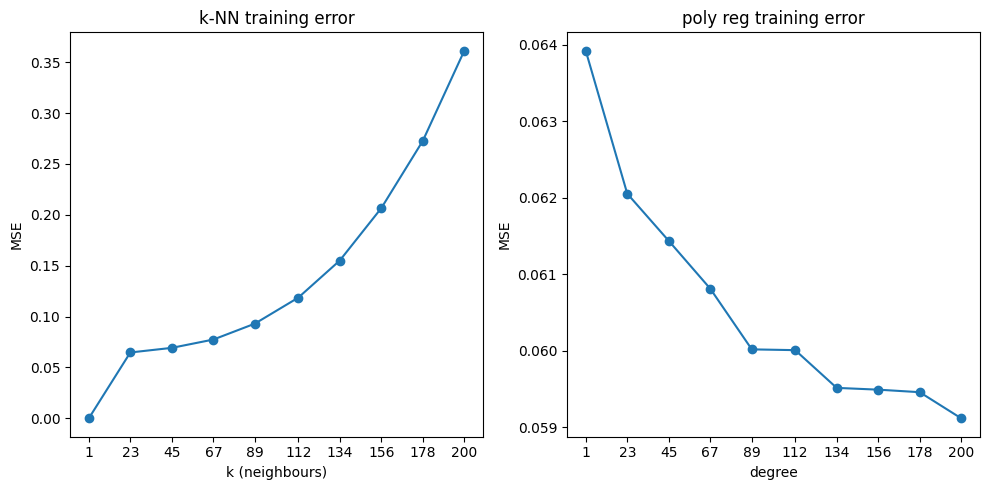

In [ ]:
fig , (ax_left, ax_right) = subplots(nrows   = 1,
                                     ncols   = 2,
                                     figsize = (10, 5))

# knn plot

# vectorize dictionary entries with list comprehension
train_errors_knn = np.array([results_knn[k]["err_train"] for k in ks])

ax_left.plot(ks, train_errors_knn, marker="o")

ax_left.set_xticks(ks)
ax_left.set_xlabel("k (neighbours)")
ax_left.set_ylabel("MSE")
ax_left.set_title("k-NN training error")


# poly plot

train_errors_poly = np.array([results_poly[d]["err_train"] for d in degrees])

ax_right.plot(degrees, train_errors_poly, marker="o")

ax_right.set_xticks(degrees)
ax_right.set_xlabel("degree")
ax_right.set_ylabel("MSE")
ax_right.set_title("poly reg training error")


fig.tight_layout();

## Plot the models

Plot the different models against the training data for the different values of the parameter (displayed with a color gradient).

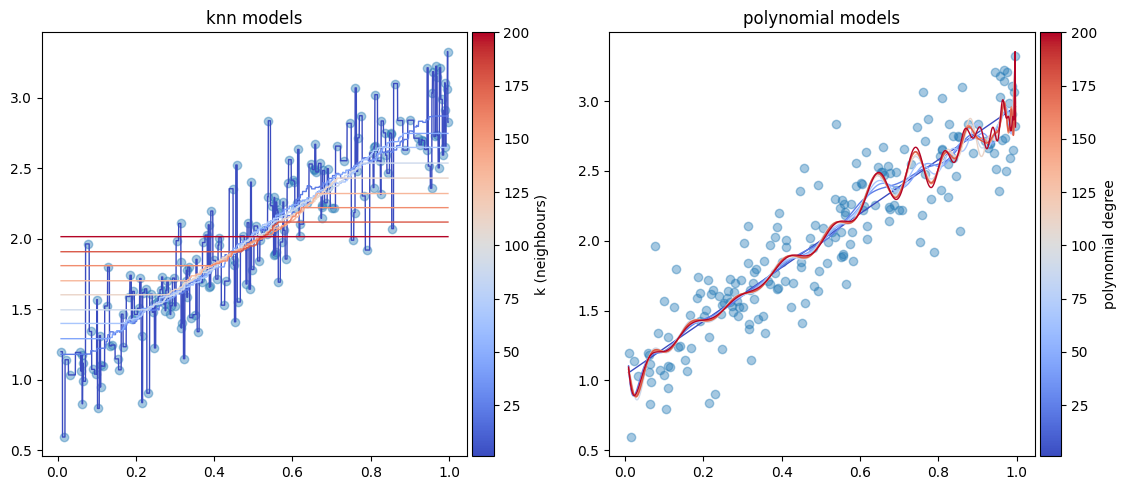

In [ ]:
fig , (ax_left, ax_right) = subplots(nrows   = 1,
                                     ncols   = 2,
                                     figsize = (11.5, 5))

# setup colormap
cmap = colormaps.get_cmap("coolwarm")
norm_k = Normalize(vmin=min(ks),      vmax=max(ks))
norm_d = Normalize(vmin=min(degrees), vmax=max(degrees))

# generate a fine grid
x_plot = np.linspace(X.min(), X.max(), 5000).reshape(-1,1)


# knn plot

ax_left.scatter(X, Y, alpha=0.4)          # scatter the data (semi-transparent)

for k, info in results_knn.items():       # iterate on the dictionary
  y_plot = info["model"].predict(x_plot)  # predict on the grid
  ax_left.plot(x_plot[:,0], y_plot, label=f"{k}", color=cmap(norm_k(k)), lw=1)

# plot colorbar
sm_k = ScalarMappable(cmap=cmap, norm=norm_k)
sm_k.set_array([])
cbar_k = fig.colorbar(sm_k, ax=ax_left, pad=0.01)
cbar_k.set_label("k (neighbours)")

ax_left.set_title("knn models")
#ax_left.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# poly plot

ax_right.scatter(X, Y, alpha=0.4)

for d, info in results_poly.items():
  xp_plot = info["poly"].transform(x_plot)
  y_plot = info["model"].predict(xp_plot)
  ax_right.plot(x_plot[:,0], y_plot, label=f"{d}", color=cmap(norm_d(d)), lw=1)

sm_d = ScalarMappable(cmap=cmap, norm=norm_d)
sm_d.set_array([])
cbar_d = fig.colorbar(sm_d, ax=ax_right, pad=0.01)
cbar_d.set_label("polynomial degree")

ax_right.set_title("polynomial models")
#ax_right.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout();

The knn model
- for maximum $k$ is an horizontal line (using all training set as neighbours)
- for middle values it's an approximate diagonal line at the center and turns horizontal at the edges (likely a clipping phenomenon due to the fact the neighbours are mostly on one side)
- at $\ k = 1\ $ it interpolates the training points

The polynomial models instead stay mainly on the diagonal and get more wobbly as the degree gets higher; \
for degree $1$ it's a straight line and for degree $\geq n-1$ it (should) interpolate. \
However they seem suspiciously well behaved for such high degrees (cfr. Runge phenomenon).

Indeed this is just a coincidence due to a particularly lucky choice of the training set, as we can see by changing the random seed.

0.048311315767599596

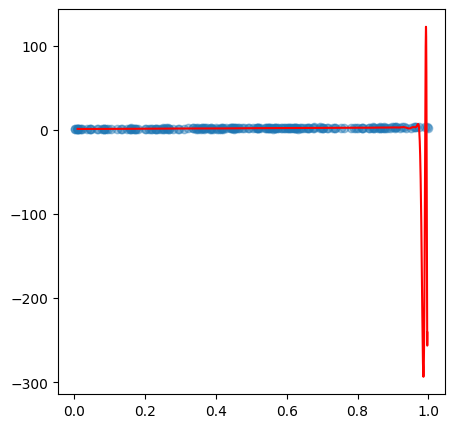

In [ ]:
rng_bad = np.random.default_rng(17)
X_bad = rng_bad.random((n,1))
Y_bad = (a*X_bad + b) + rng_bad.normal(loc=0, scale=sigma, size=X_bad.shape)

high_d = max(degrees)
# use a pipeline to bundle transform + fit + predict steps
poly = make_pipeline(
    PolynomialFeatures(degree=high_d, include_bias=True),
    LinearRegression()
)
poly.fit(X_bad, Y_bad)

y_pred_bad = poly.predict(X_bad)
y_plot     = poly.predict(x_plot)
err_bad = mean_squared_error(Y_bad, y_pred_bad)

display(err_bad)
fig , ax = subplots(figsize = (5, 5))
ax.scatter(X_bad, Y_bad, alpha=0.4)
ax.plot(x_plot, y_plot, color="red");

Even though the training error is small, since the polynomial is trying to interpolate, the huge swings will surely lead to unreasonably high test errors.

It is interesting to note that the solution of least square for a polynomial of degree $\geq n-1$ on $n$ points should be an exact interpolation, leading to $0$ training errors.
However we still see errors of order $\sim 10^{-2}$.

Solving a linear least square problem

$$ \min_{\beta} \lVert V\beta - y \rVert_2^2 $$

boils down to solving the linear system

$$ V^T V \beta = V^T y $$

or equivalently computing the pseudoinverse via SVD decomposition

$$ V = U \Sigma W^T \\ V^+ = W \Sigma^{-1} U^T \\ \beta = V^+ y $$

where the desing matrix $V$ is the Vandermonde matrix

$$
V =
\begin{pmatrix}
  1 & x_1 & x_1^2 & \cdots & x_1^d \\
  1 & x_2 & x_2^2 & \cdots & x_2^d \\
  \vdots & & & & \vdots \\
  1 & x_n & x_n^2 & \cdots & x_n^d
\end{pmatrix}
$$

This matrix is horribly ill-conditioned (condition number grows exponentially in $d$), thus numerical errors get amplified a lot.

scikit-learn’s `LinearRegression` calls the SVD solver `np.linalg.lstsq()` with a small `rcond` threshold: small singular values are cutoff to $0$ to improve stability.

Fiddling around, we see that we can get a smaller error (but not much) by employing Chebyshev polynomials instead of the monomial basis, and by adjusting `rcond`. Unfortunately if we set a value too low we will amplify noise, producing worse errors. I had no success by employing a direct solver, nor by increasing numerical precision.

/usr/local/lib/python3.11/dist-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


0.008471011210309748

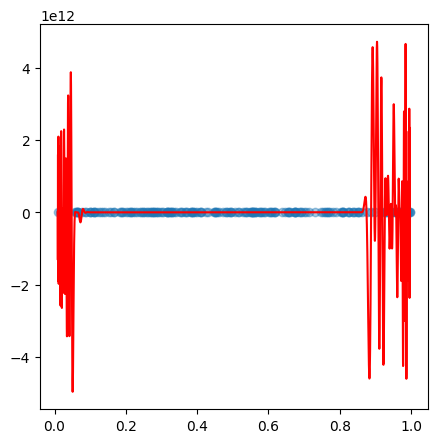

In [ ]:
cheb = np.polynomial.chebyshev.Chebyshev.fit(
    X.ravel(), Y.ravel(),
    deg    = n-1,
    domain = [X.min(), X.max()],
    rcond  = 1e-14
)
y_pred = cheb(X.ravel())
y_plot = cheb(x_plot.ravel())
err = mean_squared_error(Y, y_pred)

display(err)
fig , ax = subplots(figsize = (5, 5))
ax.scatter(X, Y, alpha=0.4)
ax.plot(x_plot, y_plot, color="red");

Still the interpolating polynomial would perform horribly on a test set.

## Average across many samples

Write a function to make it easier to train and test on different samples.

In [ ]:
def train_test_knn(X_train, Y_train, X_test, Y_test, k):
  '''
  Train and test a k-nearest-neighbours model.

  Args:
    X_train (np.array (n,1)) : training set features
    Y_train (np.array (n,1)) : training set labels
    X_test  (np.array (n,1)) : test set features
    Y_test  (np.array (n,1)) : test set labels
    k (int) : number of neighbours (parameter)

  Returns:
    knn : knn model
    err_train (float): training error
    err_test  (float): test error
  '''

  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train, Y_train)

  y_pred_train = knn.predict(X_train)
  err_train = mean_squared_error(Y_train, y_pred_train)

  y_pred_test = knn.predict(X_test)
  err_test = mean_squared_error(Y_test, y_pred_test)

  return (knn, err_train, err_test)



def train_test_poly(X_train, Y_train, X_test, Y_test, d):
  '''
  Train and test a polynomial regression model.

  Args:
    X_train (np.array (n,1)) : training set features
    Y_train (np.array (n,1)) : training set labels
    X_test  (np.array (n,1)) : test set features
    Y_test  (np.array (n,1)) : test set labels
    d (int) : polynomial degree (parameter)

  Returns:
    poly : polynomial regression model
    err_train (float): training error
    err_test  (float): test error
  '''

  poly = make_pipeline(
      PolynomialFeatures(degree=d, include_bias=True),
      LinearRegression()
  )
  poly.fit(X_train, Y_train)

  y_pred_train = poly.predict(X_train)
  err_train = mean_squared_error(Y_train, y_pred_train)

  y_pred_test = poly.predict(X_test)
  err_test = mean_squared_error(Y_test, y_pred_test)

  return (poly, err_train, err_test)

Define $f$ with a lambda function, create parameters of appropriate size, generate test sample.

In [ ]:
f = lambda x: a*x + b
ks = degrees = list(map(round, np.linspace(1, n/10, m)))

X_test = rng.random((n,1))
Y_test = list(map(f, X_test)) + rng.normal(loc=0, scale=sigma, size=X_test.shape)

#fig, ax = subplots(figsize=(3,3))
#ax.scatter(X_test, Y_test, s=10);

Train on multiple samples, compute training and test errors, average across the samples.

In [ ]:
s = 5    # number of samples

# initialize matrices for (sample, parameter) entries
KNN            = np.empty((s, len(ks)), dtype=object)
ERR_train_knn  = np.empty((s, len(ks)))
ERR_test_knn   = np.empty((s, len(ks)))
POLY           = np.empty((s, len(degrees)), dtype=object)
ERR_train_poly = np.empty((s, len(degrees)))
ERR_test_poly  = np.empty((s, len(degrees)))

#fig, axes = subplots(nrows=1, ncols=5, figsize=(15, 3))

for i in range(s):
  X_train = rng.random((n,1))
  Y_train = list(map(f, X_train)) + rng.normal(loc=0, scale=sigma, size=X_train.shape)

  for j, k in enumerate(ks):
    KNN[i,j], ERR_train_knn [i,j], ERR_test_knn  [i,j] \
      = train_test_knn (X_train, Y_train, X_test, Y_test, k)
  for j, d in enumerate(degrees):
    POLY[i,j], ERR_train_poly[i,j], ERR_test_poly [i,j] \
      = train_test_poly(X_train, Y_train, X_test, Y_test, d)

  #axes[i].scatter(X_train, Y_train, s=10);

mean_train_knn  = ERR_train_knn .mean(axis=0)
mean_test_knn   = ERR_test_knn  .mean(axis=0)
mean_train_poly = ERR_train_poly.mean(axis=0)
mean_test_poly  = ERR_test_poly .mean(axis=0)

Plot the errors: training on the left and test on the right, top for knn and bottom for polynomial [*too lazy to make the labels*].

Notice that for the knn on the x axis there is $\frac{1}{k}$, so that the training error decreases moving to the right (increasing complexity).

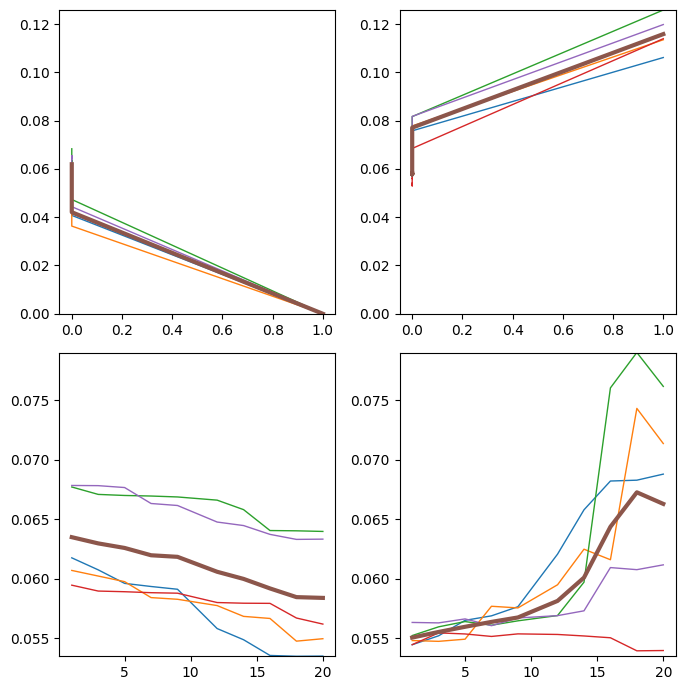

In [ ]:
fig , ((ax_up_left,   ax_up_right),
       (ax_down_left, ax_down_right)) = subplots(nrows   = 2,
                                                 ncols   = 2,
                                                 figsize = (7, 7))
# plot the error for each sample
for i in range(s):
  ax_up_left   .plot(np.reciprocal(ks), ERR_train_knn[i],  lw=1)
  ax_up_right  .plot(np.reciprocal(ks), ERR_test_knn[i],   lw=1)
  ax_down_left .plot(degrees, ERR_train_poly[i], lw=1)
  ax_down_right.plot(degrees, ERR_test_poly[i],  lw=1)

# plot the average error across samples
ax_up_left   .plot(np.reciprocal(ks), mean_train_knn,  lw=3)
ax_up_right  .plot(np.reciprocal(ks), mean_test_knn,   lw=3)
ax_down_left .plot(degrees, mean_train_poly, lw=3)
ax_down_right.plot(degrees, mean_test_poly,  lw=3)

# use same y scale to compare the errors
min_knn = np.min([np.min(ERR_train_knn), np.min(ERR_test_knn)])
max_knn = np.max([np.max(ERR_train_knn), np.max(ERR_test_knn)])
ax_up_left .set_ylim(min_knn, max_knn)
ax_up_right.set_ylim(min_knn, max_knn)
min_poly = np.min([np.min(ERR_train_poly), np.min(ERR_test_poly)])
max_poly = np.max([np.max(ERR_train_poly), np.max(ERR_test_poly)])
ax_down_left .set_ylim(min_poly, max_poly)
ax_down_right.set_ylim(min_poly, max_poly)

fig.tight_layout();

Notice that in both cases increasing complexity leads to lower training error but higher test error. \
This is to be expected given that the generating data is linear (up to noise); so lower complexity models will perform better, while higher complexity ones will overfit.

## Change distribution

Let's try different data distributions by changing $f$. \
Pack everything so far into a single function.

In [ ]:
def stuff(f):
  ks = degrees = list(map(round, np.linspace(1, n/10, m)))
  s = 5

  X_test = rng.random((n,1))
  Y_test = list(map(f, X_test)) + rng.normal(loc=0, scale=sigma, size=X_test.shape)

  KNN            = np.empty((s, len(ks)), dtype=object)
  ERR_train_knn  = np.empty((s, len(ks)))
  ERR_test_knn   = np.empty((s, len(ks)))
  POLY           = np.empty((s, len(degrees)), dtype=object)
  ERR_train_poly = np.empty((s, len(degrees)))
  ERR_test_poly  = np.empty((s, len(degrees)))

  for i in range(s):
    X_train = rng.random((n,1))
    Y_train = list(map(f, X_train)) + rng.normal(loc=0, scale=sigma, size=X_train.shape)

    for j, k in enumerate(ks):
      KNN[i,j], ERR_train_knn [i,j], ERR_test_knn  [i,j] \
        = train_test_knn (X_train, Y_train, X_test, Y_test, k)
    for j, d in enumerate(degrees):
      POLY[i,j], ERR_train_poly[i,j], ERR_test_poly [i,j] \
        = train_test_poly(X_train, Y_train, X_test, Y_test, d)

  mean_train_knn  = ERR_train_knn .mean(axis=0)
  mean_test_knn   = ERR_test_knn  .mean(axis=0)
  mean_train_poly = ERR_train_poly.mean(axis=0)
  mean_test_poly  = ERR_test_poly .mean(axis=0)


  fig , ((ax_up_left,   ax_up_right),
        (ax_down_left, ax_down_right)) = subplots(nrows   = 2,
                                                  ncols   = 2,
                                                  figsize = (7, 7))

  for i in range(s):
    ax_up_left   .plot(np.reciprocal(ks), ERR_train_knn[i],  lw=1)
    ax_up_right  .plot(np.reciprocal(ks), ERR_test_knn[i],   lw=1)
    ax_down_left .plot(degrees, ERR_train_poly[i], lw=1)
    ax_down_right.plot(degrees, ERR_test_poly[i],  lw=1)

  ax_up_left   .plot(np.reciprocal(ks), mean_train_knn,  lw=3)
  ax_up_right  .plot(np.reciprocal(ks), mean_test_knn,   lw=3)
  ax_down_left .plot(degrees, mean_train_poly, lw=3)
  ax_down_right.plot(degrees, mean_test_poly,  lw=3)

  min_knn = np.min([np.min(ERR_train_knn), np.min(ERR_test_knn)])
  max_knn = np.max([np.max(ERR_train_knn), np.max(ERR_test_knn)])
  ax_up_left .set_ylim(min_knn, max_knn)
  ax_up_right.set_ylim(min_knn, max_knn)
  min_poly = np.min([np.min(ERR_train_poly), np.min(ERR_test_poly)])
  max_poly = np.max([np.max(ERR_train_poly), np.max(ERR_test_poly)])
  ax_down_left .set_ylim(min_poly, max_poly)
  ax_down_right.set_ylim(min_poly, max_poly)

  fig.tight_layout();

Now just pass the desired lambda function.

For example $\ f(x) = x^2 + 2x + 1 $

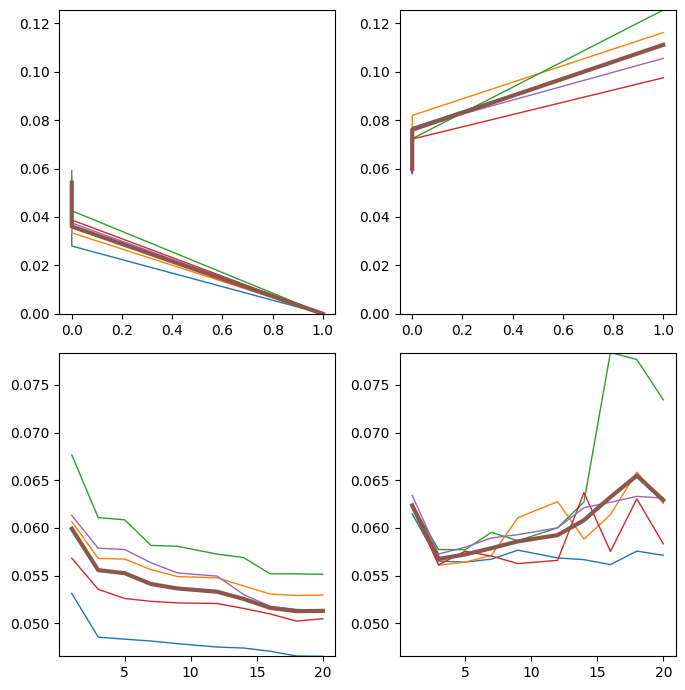

In [ ]:
f = lambda x: x**2 + 2*x + 1
stuff(f)

or $\ f(x) = x^9 + 2x^8 + 3x^7 + ... + 8x^2 + 9x + 10 $

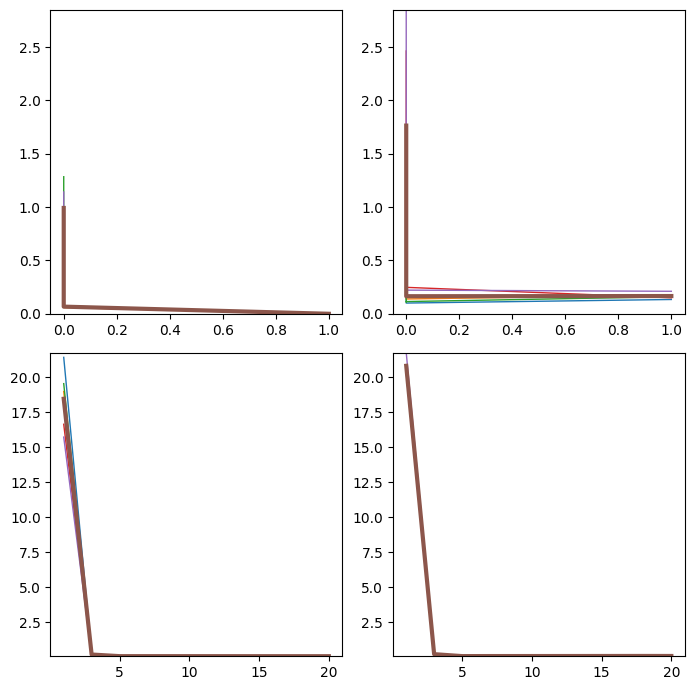

In [ ]:
f = lambda x: sum((10 - i) * x**i for i in range(10))
stuff(f)

or $\ f(x) = \sin(x)$

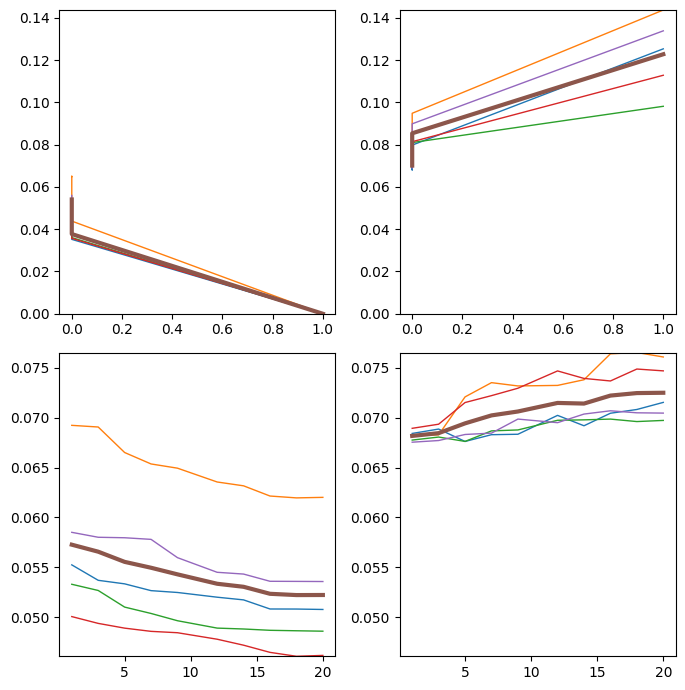

In [ ]:
f = lambda x: np.sin(x)
stuff(f)

or $\ f(x) = e^x$

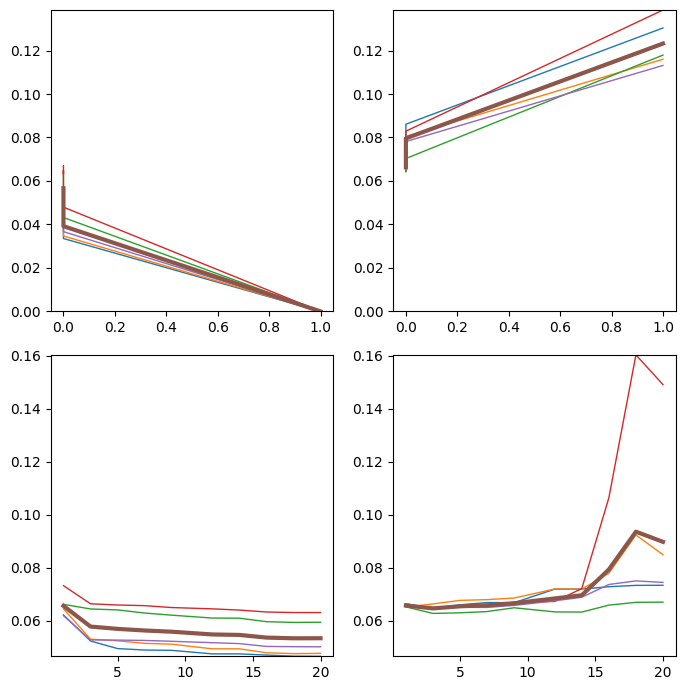

In [ ]:
f = lambda x: np.exp(x)
stuff(f)

There are many behaviours we could explore, but we would need to unpack everything and further customize the code case by case.

For example we notice that for the degree $2$ polynomial, the dip in the test error occurs around $2$ or $3$, as we would expect. \
Instead for the degree $9$ polynomial, low degree polynomials underfit a lot, thus obscuring what's going on for higher values of the parameter. We would need to adjust the plot `y_lim` to a reasonable cutoff or throw away the problematic values.

For this reason, we conclude here.